In [18]:
import os
import numpy as np
from abc import ABC, abstractmethod
from jpype import *
import tqdm
import matplotlib.pyplot as plt
from scipy.signal import convolve



In [21]:
from utils import participant_ids, raw_data_path, find_trials, import_soa_rating_data, import_emg_data, onset_detection, extract_onset_time

In [6]:
import pandas as pd

ni_file = "../../data/raw_20250911/NI/20250604/1_20250604_135334_ni.txt"
data_emg = pd.read_csv(ni_file, sep="\t")

display(data_emg.head())


,Time[s],ACC_HIHAT[V],ACC_SNARE[V],EMG1[V],EMG2[V],EMG3[V],EMG4[V],TRIGER[V],Correct_Timing_Signal[V]
0,0.0000,0.001615,-0.000359,0.010331,0.035495,0.015101,0.147002,0.000135,0.002437
1,0.0001,-0.000030,-0.000030,0.009838,0.037962,0.012963,0.149469,0.000135,0.004082
2,0.0002,0.001286,-0.000030,0.009016,0.039113,0.011812,0.150949,0.000135,0.001779
3,0.0003,-0.000852,0.000464,0.009345,0.040100,0.006713,0.150126,-0.000194,-0.000688
4,0.0004,-0.000194,-0.000359,0.010331,0.040593,-0.000852,0.147988,-0.000030,0.000628


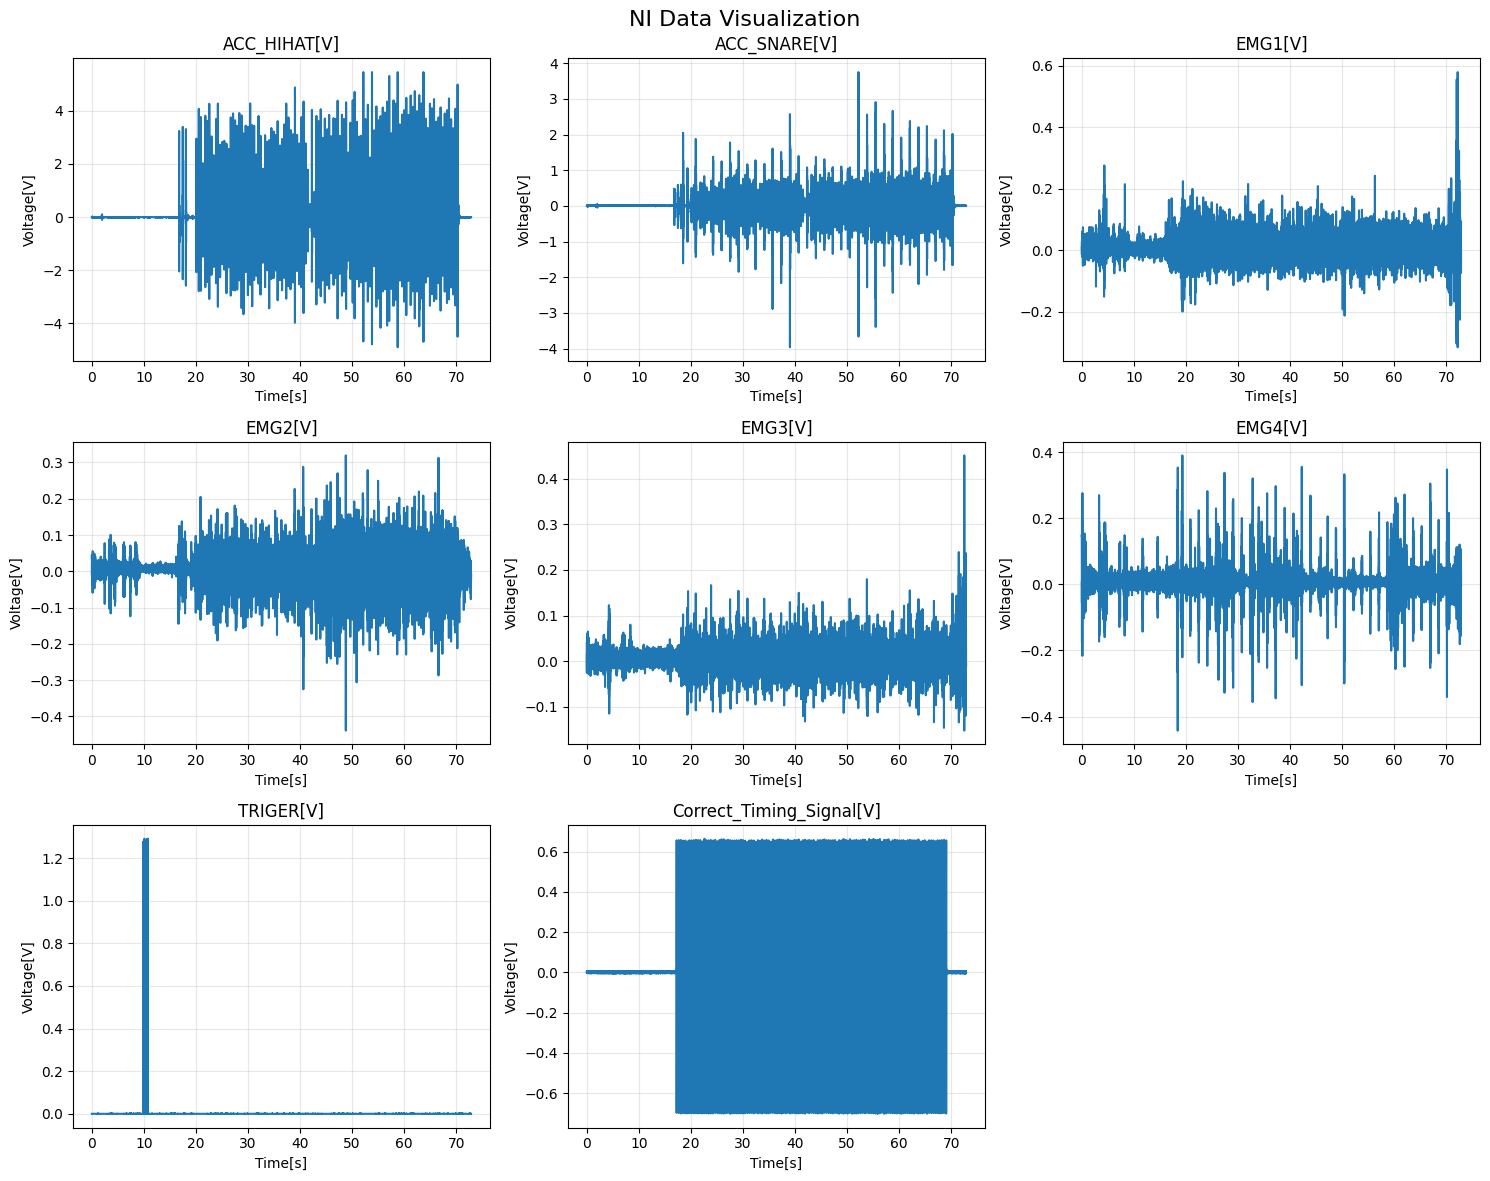

In [7]:
# plot df
import matplotlib.pyplot as plt

# Create subplots for different columns
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle('NI Data Visualization', fontsize=16)

# Plot each column (excluding Time)
columns_to_plot = data_emg.columns[1:]  # Skip the Time column
for i, col in enumerate(columns_to_plot):
    row = i // 3
    col_idx = i % 3
    
    axes[row, col_idx].plot(data_emg['Time[s]'], data_emg[col])
    axes[row, col_idx].set_title(col)
    axes[row, col_idx].set_xlabel('Time[s]')
    axes[row, col_idx].set_ylabel('Voltage[V]')
    axes[row, col_idx].grid(True, alpha=0.3)

# Remove empty subplot if any
if len(columns_to_plot) < 9:
    for i in range(len(columns_to_plot), 9):
        row = i // 3
        col_idx = i % 3
        fig.delaxes(axes[row, col_idx])

plt.tight_layout()
plt.show()


Correlation Matrix:


,ACC_HIHAT[V],ACC_SNARE[V],EMG1[V],EMG2[V],EMG3[V],EMG4[V],TRIGER[V],Correct_Timing_Signal[V]
ACC_HIHAT[V],1.000000,-0.015480,0.005305,-0.002108,0.001093,0.000177,-1.078331e-06,-2.481800e-02
ACC_SNARE[V],-0.015480,1.000000,0.038648,-0.002596,0.007200,0.003177,-7.867911e-06,-4.606827e-03
EMG1[V],0.005305,0.038648,1.000000,0.059804,0.011076,0.003016,6.944320e-04,2.329756e-04
EMG2[V],-0.002108,-0.002596,0.059804,1.000000,0.011806,0.013796,1.049535e-04,-2.096463e-03
EMG3[V],0.001093,0.007200,0.011076,0.011806,1.000000,0.040486,1.176855e-04,-3.335005e-03
EMG4[V],0.000177,0.003177,0.003016,0.013796,0.040486,1.000000,-7.577319e-05,-4.281692e-03
TRIGER[V],-0.000001,-0.000008,0.000694,0.000105,0.000118,-0.000076,1.000000e+00,1.227151e-07
Correct_Timing_Signal[V],-0.024818,-0.004607,0.000233,-0.002096,-0.003335,-0.004282,1.227151e-07,1.000000e+00


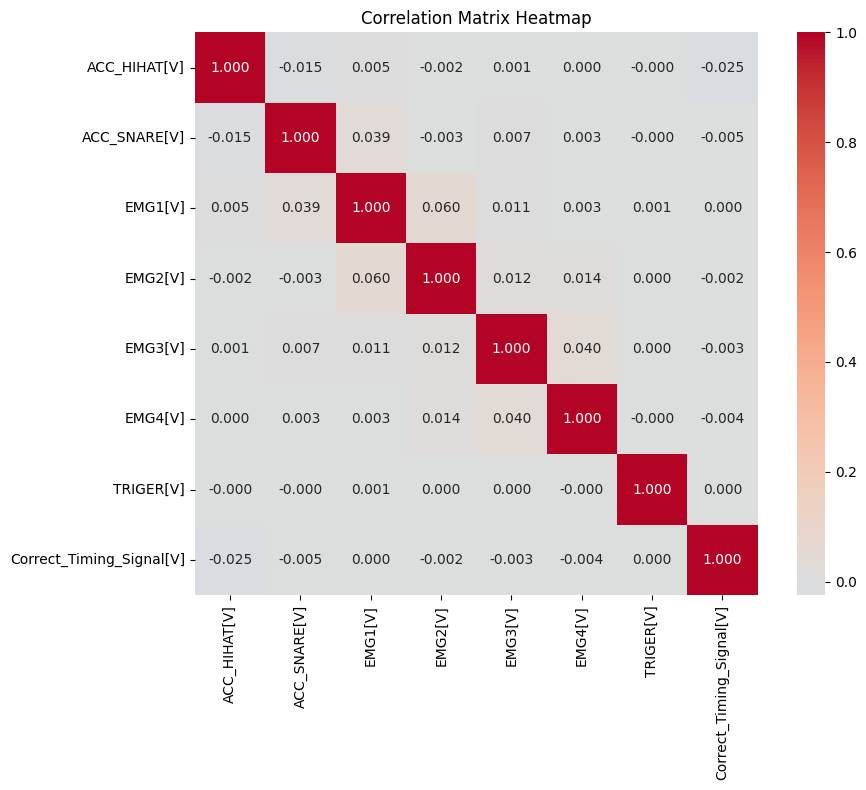


No highly correlated pairs found (|correlation| > 0.7)


In [8]:
# Compute correlation matrix between all columns (excluding Time)
correlation_matrix = data_emg.iloc[:, 1:].corr()

# Display the correlation matrix
print("Correlation Matrix:")
display(correlation_matrix)

# Create a heatmap of the correlation matrix
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='coolwarm', 
            center=0,
            square=True,
            fmt='.3f')
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()

# Find highly correlated pairs (absolute correlation > 0.7)
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.7:
            high_corr_pairs.append((
                correlation_matrix.columns[i], 
                correlation_matrix.columns[j], 
                corr_val
            ))

if high_corr_pairs:
    print("\nHighly correlated pairs (|correlation| > 0.7):")
    for col1, col2, corr in high_corr_pairs:
        print(f"{col1} - {col2}: {corr:.3f}")
else:
    print("\nNo highly correlated pairs found (|correlation| > 0.7)")


In [11]:
from utils import participant_ids, raw_data_path, find_trials, import_soa_rating_data, import_emg_data
import numpy as np 
import pandas as pd


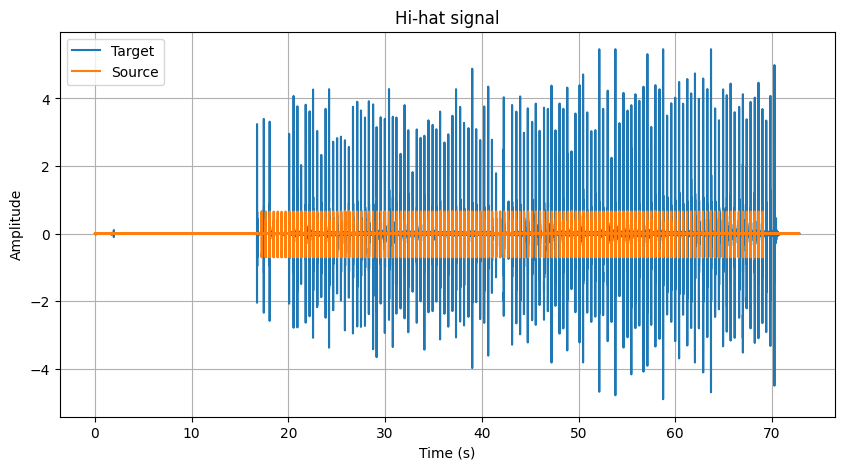

In [16]:
target = data_emg['ACC_HIHAT[V]'].values
source = data_emg['Correct_Timing_Signal[V]'].values
t = data_emg['Time[s]'].values

# plot the target signal
fig = plt.figure(figsize=(10, 5))
plt.plot(t, target)
plt.plot(t, source)
plt.legend(['Target', 'Source'])
plt.title('Hi-hat signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
# plt.xlim([20, 30])
plt.grid(True)
plt.show()

    

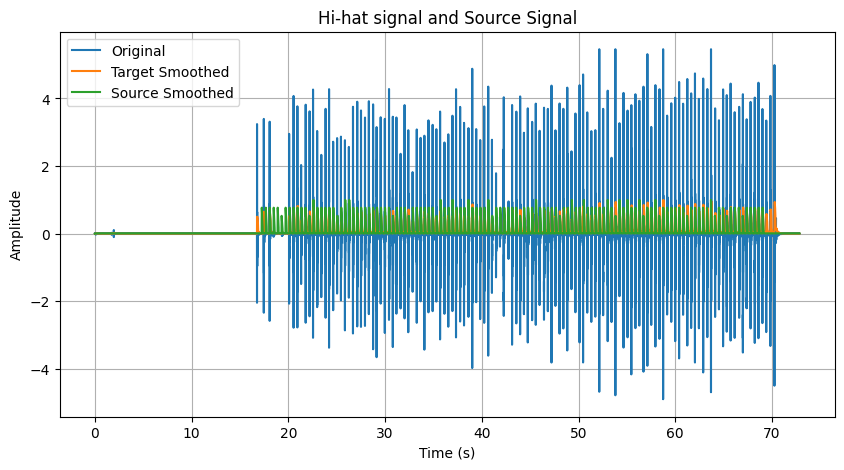

In [19]:
# convolue
def convolve_with_exponential_kernel(data, decay_rate, kernel_size):
    """
    Convolve a column with an exponential kernel for smoothing.

    Parameters:
    - data (np.array): The data to be smoothed.
    - decay_rate (float): The decay rate (lambda) for the exponential kernel.

    Returns:
    - np.array: The convolved data.
    """
    kernel = np.exp(-decay_rate * np.linspace(0, 1, kernel_size))
    # kernel /= kernel.sum()  # Normalize kernel to maintain scale

    data_cov = np.convolve(data, kernel, mode="same")
    return data_cov


def impulse_response_convolution(
    data, peak_amplitude=1.0, decay_rate=0.001, response_length=200
):
    """
    Applies an impulse response function with exponential decay using convolution.

    Parameters:
        time_series (numpy array): The input time series (e.g., binary impulses).
        peak_amplitude (float): The peak height of the response.
        decay_rate (float): The exponential decay rate (higher means faster decay).
        response_length (int): The length of the impulse response function.

    Returns:
        numpy array: The output signal with impulse responses applied.
    """
    # Generate the impulse response kernel
    data = np.abs(data)
    t = np.arange(response_length)
    impulse_response_kernel = peak_amplitude * np.exp(-decay_rate * t)

    # Apply convolution
    output_signal = convolve(data, impulse_response_kernel, mode="full")[: len(data)]

    # Normalize the output signal
    output_signal /= np.max(output_signal)

    return output_signal



decay_rate = 0.001
response_length = 1000
target_cov = impulse_response_convolution(
    target, peak_amplitude=1, decay_rate=decay_rate, response_length=response_length
)

source_cov = impulse_response_convolution(
    source, peak_amplitude=1, decay_rate=decay_rate, response_length=response_length
)

# plot the target signal
fig = plt.figure(figsize=(10, 5))
plt.plot(t, target, label="Original")
plt.plot(t, target_cov, label="Target Smoothed")
plt.plot(t, source_cov, label="Source Smoothed")
plt.title("Hi-hat signal and Source Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
# plt.xlim([20, 30])
plt.legend()
plt.grid(True)
plt.show()

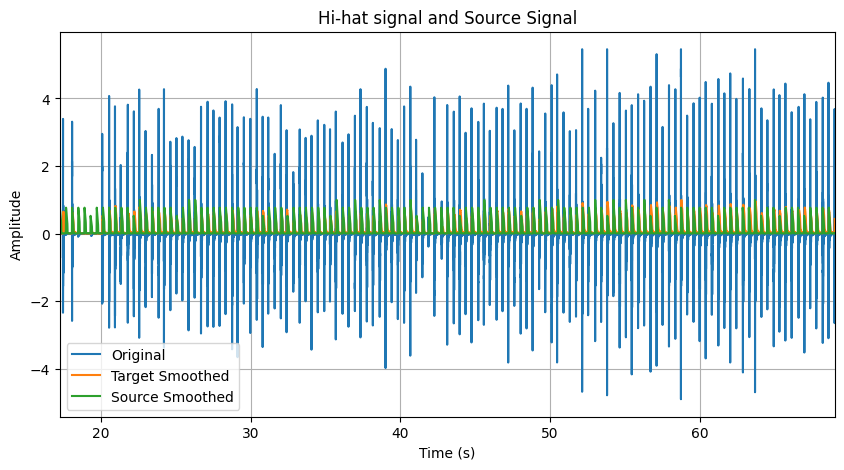

In [22]:
# find the first and last source onset
onsets_array, onset_idx = onset_detection(source, threshold=0.1, minimal_interval=1000)
idx_start = onset_idx[0]
idx_end = onset_idx[-1]

# plot the target signal
fig = plt.figure(figsize=(10, 5))  
plt.plot(t, target, label="Original")
plt.plot(t, target_cov, label="Target Smoothed")
plt.plot(t, source_cov, label="Source Smoothed")
plt.title("Hi-hat signal and Source Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.xlim([t[idx_start], t[idx_end]])
plt.legend()
plt.grid(True)
plt.show()


In [25]:
# truncate the signals
target_ = target_cov[idx_start:idx_end]
source_ = source_cov[idx_start:idx_end]
t_ = t[idx_start:idx_end]

# down sample the signals
# original sampling rate is 4000 Hz
original_sampling_rate = 10000
down_sampling_rate = 100 # Hz
down_sample_point = int(original_sampling_rate / down_sampling_rate)
target_ = target_[::down_sample_point]
source_ = source_[::down_sample_point]
t_ = t_[::down_sample_point]

In [27]:
# locate jitd jar file
from pathlib import Path
import sys

sys.path.append(
    "../"
)


from TE import TransferEntropyCalculator_continuous_kraskov

te_calc = TransferEntropyCalculator_continuous_kraskov()
te_calc.compute_TE(source_, target_, isPrintEstimation=True)

TE was optimised via Ragwitz criteria: k=6, k_tau=3, l=6, l_tau=6


0.02901197142154155

In [37]:
# create a function to compute TE from input file with above preprocessing
def compute_TE_from_input_file(file_path):
    # Load data
    data = pd.read_csv(file_path)
    data = pd.read_csv(file_path, sep="\t")

    
    # Extract signals
    target = data['ACC_HIHAT[V]'].values
    source = data['Correct_Timing_Signal[V]'].values
    t = data['Time[s]'].values
    
    # Apply convolution smoothing
    decay_rate = 0.001
    response_length = 1000
    target_cov = impulse_response_convolution(
        target, peak_amplitude=1, decay_rate=decay_rate, response_length=response_length
    )

    source_cov = impulse_response_convolution(
        source, peak_amplitude=1, decay_rate=decay_rate, response_length=response_length
    )

    
    # Find signal boundaries (non-zero regions)
    onsets_array, onset_idx = onset_detection(source, threshold=0.1, minimal_interval=1000)
    idx_start = onset_idx[0]
    idx_end = onset_idx[-1]
    
    # Truncate the signals
    target_ = target_cov[idx_start:idx_end]
    source_ = source_cov[idx_start:idx_end]
    t_ = t[idx_start:idx_end]
    
    # Down sample the signals
    original_sampling_rate = 10000
    down_sampling_rate = 100  # Hz
    down_sample_point = int(original_sampling_rate / down_sampling_rate)
    target_ = target_[::down_sample_point]
    source_ = source_[::down_sample_point]
    t_ = t_[::down_sample_point]
    
    # Compute Transfer Entropy
    te_calc = TransferEntropyCalculator_continuous_kraskov()
    te_result = te_calc.compute_TE(source_, target_, isPrintEstimation=True)
    
    return te_result

# Test the function with the current file
file_path = "../../data/raw_20250911/NI/20250604/1_20250604_135334_ni.txt"
te_result = compute_TE_from_input_file(file_path)
print(f"Transfer Entropy result: {te_result}")


TE was optimised via Ragwitz criteria: k=6, k_tau=3, l=6, l_tau=6
Transfer Entropy result: 0.02901197142154155
